<a href="https://colab.research.google.com/github/mahault/environmental-sickness-estimation/blob/main/sickboi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorials with useful elements

Source of code: https://colab.research.google.com/drive/16p4YT75ShrW5dD0d2DUL9ayUx98sdPgM 

In [1]:
!pip3 install inferactively-pymdp



You should consider upgrading via the '/Users/alexanderkiefer/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pymdp
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import copy

from scipy.special import softmax

AGELESS VERSION

#Observations
space colors (microbiome and environmental constraint) : red, blue, green for each square
age : 0-30
location : 0,1,2,3,4,5,6,7,8
symptom1 : yes, no
symptom2 : yes, no
symptom3 : yes, no
"b_m_1":["yes", "no"],
"b_m_2":["yes", "no"],
"b_m_3":["yes", "no"]

#States
Health load : not loaded, a little loaded, overloaded
location:  0,1,2,3,4,5,6,7,8
space color : red, blue, green for each square
age: 0- 30
has had sym1 :yes, no
has had symp2 : yes, no
has had symp3 : yes, no

#things that are related
space color and location
Generate a grid with those properties
symptom and bm are related
add a property to the agent of the biomarker
age is defined by the Time t

In [3]:
def get_B_location(n: int=3):
    """Automatically fill out B matrix for (up, down, left, right, stay) movement on a (n x n) grid"""

    #     1
    #     ^
    #     |
    #3<---4---->2
    #     |
    #     v
    #     0
    
    squares = n**2
    B = np.zeros((squares, squares, 5),dtype='int')

    for x in range(squares):
        B[x,x,4] = 1  # Stay at location
        B[x,x-1,2] = 1  # Move right
        B[x-1,x,3] = 1  # Move left
    
    for x in range(squares-n):
        B[x+n, x, 0] = 1 # Move down
      
    for x in range(n, squares):
        B[x-n, x, 1] = 1 # Move up
          
    for x in range(squares):
      if x < n:  # Restrict top row movement
          B[x,x,1] = 1
      if x%n == 0:  # Restrict left column movement
          B[:,x,3] = 0
          B[x,x,3] = 1
      if x >= squares - n:  # Restrict bottom row movement
          B[x,x,0] = 1
      if (x-(n-1))%n == 0:  # Restrict right column movement
          B[:,x,2] = 0
          B[x,x,2] = 1
    
    return B

The Basic components of the model


The Grid

In [4]:
# TODO : Use `age` state to influence epistemic value (via influencing preference strength for health)
# TODO : Build in differences between pathogens; different squares could have different volatilities (both "good" and "bad" - some pathogens should be avoided period)


### Actual world grid
Grid  = [0,1,2,0,1,2,0,1,2]

###b matrix of the grid changing to another color in the generative process
##0-0, 0-1, 0-2, 1-0,1-1, 1-2, 2-0, 2-1, 2-2
Grid_B = np.zeros((3,3))
Grid_B[:,:] = .05
Grid_B[0,0] = .9
Grid_B[1,1] = .9
Grid_B[2,2] = .9

list_of_symptoms = ["red", "blue", "green"]
health_labels = ["not loaded", "a little loaded", "overloaded"]
control_state = "location"



Gets observations from Grid

In [5]:
def get_space_colors_from_grid(labels=list_of_symptoms):
    for i,e in enumerate(Grid):
        observations[f"space_colors_{i}"] = labels

    
def get_location_from_grid():
    observations["location"] = list(range(len(Grid)))

def get_symptom(labels=list_of_symptoms):
    for i,label in enumerate(labels):
        observations[f"symptom_{label}"] = ["no", "yes"]

def get_biomarker(labels=list_of_symptoms):
    for i,label in enumerate(labels):
        observations[f"b_m_{label}"] = ["no", "yes"]

# get_biomarker()
# print(observations)

Test the observation from grid functions

In [11]:
assert len(Grid) == len([key for key in observations.keys()  if "space_colors" in key] ), f"There isn't the same number of observation for space colors as there are grid spaces. Grid spaces = {len(Grid)}  space_colors observations = {len([key for key in observations.keys()  if 'space_colors' in key])}"

In [12]:
assert len(Grid) == len(observations["location"]), f"there isn't the same number of location indices in observations: {len(observations.location)} as there are grid spaces: {len(Grid)}"

In [13]:
assert len(list_of_symptoms) == len([observation for observation in observations.keys() if "symptom" in observation]), f"There isn't the same number of sumptoms: {len(list_of_symptoms)} as there are observations about symptoms : {len([observation for observation in observations.keys() if 'symptom' in key]) }"

In [14]:
assert len(list_of_symptoms) == len([observation for observation in observations.keys() if "b_m_" in observation]), f"There isn't the same number of sumptoms: {len(list_of_symptoms)} as there are observations about biomarker : {len([observation for observation in observations.keys() if 'b_m_' in key]) }"

Set the observations

In [6]:
observations = {}
get_space_colors_from_grid()
get_location_from_grid()
get_symptom()
get_biomarker()

# observations =  {
#     "space_colors_0": ["red", "blue", "green"],
#     "space_colors_1": ["red", "blue", "green"],
#     "space_colors_2": ["red", "blue", "green"],
#     "space_colors_3": ["red", "blue", "green"],
#     "space_colors_4": ["red", "blue", "green"],
#     "space_colors_5": ["red", "blue", "green"],
#     "space_colors_6": ["red", "blue", "green"],
#     "space_colors_7": ["red", "blue", "green"],
#     "space_colors_8": ["red", "blue", "green"],
#     "location" : [0,1,2,3,4,5,6,7,8],
#     "symptom_red" : ["no", "yes"],
#     "symptom_blue" : ["no", "yes"],
#     "symptom_green" : ["no", "yes"],
#     "b_m_red":["no", "yes"],
#     "b_m_blue":["no", "yes"],
#     "b_m_green":["no", "yes"]
# }



Get states from grid 

In [16]:
def get_space_colors_from_grid_states(labels=list_of_symptoms):
  for i,e in enumerate(Grid):
    states[f"space_colors_{i}"] = labels

def get_location_from_grid_states():
  states["location"] = list(range(len(Grid)))

def get_has_had_symp(labels=list_of_symptoms):
  for i,label in enumerate(labels):
    states[f"has_had_symp_{label}"] = ["no", "yes"]

def get_health_load(labels=list_of_symptoms):
  states["health_load"] = list(range(len(labels) +1))




Test the functions

In [ ]:
#TODO write test function for get_space_colors_from_grid_states
assert len(Grid) == len([key for key in states.keys()  if "space_colors" in key] ), f"There isn't the same number of states for space colors as there are grid spaces. Grid spaces = {len(Grid)}  space_colors states = {len([key for key in states.keys()  if 'space_colors' in key])}"

In [ ]:
#TODO write test function for get_location_from_grid_states
assert len(Grid) == len(states["location"]), f"there isn't the same number of location indices in states: {len(states.location)} as there are grid spaces: {len(Grid)}"

In [ ]:
#TODO write test function for get_has_had_symp
assert len(list_of_symptoms) == len([state for state in states.keys() if "has_had_symp" in state]), f"There isn't the same number of sumptoms: {len(list_of_symptoms)} as there are states about symptoms : {len([state for state in states.keys() if 'symptom' in key]) }"

In [ ]:
#TODO write test function for get_health_load
assert len(list_of_symptoms)+1 == len(states["health_load"]), f"There isn't the same number of symptoms: {len(list_of_symptoms)+1} as there are Health_load states: {len(states['health_load'])}"

Set the states

In [11]:
states= {}
get_space_colors_from_grid_states()
get_location_from_grid_states()
get_has_had_symp()
get_health_load()

# states = {
#     "space_colors_0" : ["red", "blue", "green"],
#     "space_colors_1" : ["red", "blue", "green"],
#     "space_colors_2" : ["red", "blue", "green"],
#     "space_colors_3" : ["red", "blue", "green"],
#     "space_colors_4" : ["red", "blue", "green"],
#     "space_colors_5" : ["red", "blue", "green"],
#     "space_colors_6" : ["red", "blue", "green"],
#     "space_colors_7" : ["red", "blue", "green"],
#     "space_colors_8" : ["red", "blue", "green"],
#     "location" : [0,1,2,3,4,5,6,7,8],
#     "has had symp_red" : ["no", "yes"],
#     "has had symp_blue" : ["no", "yes"],
#     "has had symp_green" : ["no", "yes"],
#     "Health_load" : ["not loaded", "a little loaded", "overloaded"],
    
# }


Set the actions

In [8]:
actions = {
    "change_location"  : ["go up", "go down", "go right", "go left", "stay" ]
}

Get num observations, states, controls and factors

In [12]:
def get_num_obs_per_modality(observations):
  return [len(value) for value in observations.values()]
def get_num_obs():
  return len(observations)

def get_num_states_per_factor(states):
  return [len(value) for value in states.values()]

def get_num_states():
  return len(states)

def get_num_controls():
  # should have the same as the number of states
  # should find the index of the control state
  # should have the number of control actions for that index
  control = [1]*len(states)
  control[list(states.keys()).index("location")] = len(actions["change_location"])
  return control

def get_num_space_colors():
    return len([key for key in states.keys()  if "space_colors" in key])



Test num observations, states, controls and factors functions

In [15]:
get_num_obs()
num_controls = get_num_controls()
nsc = get_num_space_colors()

print(num_controls)
print(nsc)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1]
9


In [20]:
assert len(get_num_obs_per_modality(observations)) == len(observations), f"there isn't the same number of observations : {len(observations)} as there are observation modalities: {len(get_num_obs_per_modality(observations))} "

In [21]:
#TODO write the test for get num obs


In [22]:
#TODO write test for get num_states_per_factor

In [23]:
#TODO write test for get_num_states

In [24]:
#TODO write test for get num controls

Set num observations, states, controls and factors

In [36]:
# num_obs = [len(value) for value in observations.values()] # observation modality dimensions
# num_states = [3,3,3,3,3,3,3,3,3,9,2,2,2,3] # hidden state factor dimensions
# num_controls = [1,1,1,1,1,1,1,1,1,5,1,1,1,1] # control state factor dimensions
# num_factors = len(num_states)


num_obs = get_num_obs_per_modality(observations)
num_modalities = get_num_obs()
num_states = get_num_states_per_factor(states)
num_factors = get_num_states()
num_controls = get_num_controls()
num_space_colors = get_num_space_colors()

In [37]:
num_modalities

16

In [38]:
num_states

[3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 2, 2, 2, 4]

In [39]:
num_obs

[3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 2, 2, 2, 2, 2, 2]

Instantiating matrices

In [21]:
def inst_space_colors(num_states, list_of_symptoms):
  tot_list = [len(list_of_symptoms)]+num_states
  return np.zeros((tot_list))


def inst_location(Grid, num_states):
  tot_list = [len(Grid)]+num_states
  return np.zeros((tot_list))

def inst_symptoms(num_states):
    tot_list = [2]+num_states
    return np.zeros((tot_list))

In [22]:
states

{'space_colors_0': ['red', 'blue', 'green'],
 'space_colors_1': ['red', 'blue', 'green'],
 'space_colors_2': ['red', 'blue', 'green'],
 'space_colors_3': ['red', 'blue', 'green'],
 'space_colors_4': ['red', 'blue', 'green'],
 'space_colors_5': ['red', 'blue', 'green'],
 'space_colors_6': ['red', 'blue', 'green'],
 'space_colors_7': ['red', 'blue', 'green'],
 'space_colors_8': ['red', 'blue', 'green'],
 'location': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'has_had_symp_red': ['no', 'yes'],
 'has_had_symp_blue': ['no', 'yes'],
 'has_had_symp_green': ['no', 'yes'],
 'health_load': [0, 1, 2, 3]}

Testing functions to instantiate

In [42]:
num_obs[0]

3

Instantiate space colors

In [24]:
A_space_colors = []
for modality in range(num_space_colors):
    A_space_colors.append(inst_space_colors(num_states, list_of_symptoms))

# A_space_colors_0 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_1 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_2 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_3 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_4 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_5 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_6 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_7 = inst_space_colors(num_states, list_of_symptoms)
# A_space_colors_8 = inst_space_colors(num_states, list_of_symptoms)



Instantiate location


In [25]:
A_location = inst_location(Grid, num_states)

Instantiate symptoms

In [28]:
A_sym = []
for symptom in list_of_symptoms:
    A_sym.append(inst_symptoms(num_states))

# A_sym_red = inst_symptoms(num_states)
# A_sym_blue = inst_symptoms(num_states)
# A_sym_green = inst_symptoms(num_states)


Instantiate biomarkers

In [29]:
A_bm = []
for bm in list_of_symptoms:
    A_bm.append(inst_symptoms(num_states))
    
# A_bm_blue = inst_symptoms(num_states)
# A_bm_green = inst_symptoms(num_states)

## Fill in values

Fill in space colors values

In [54]:
for A_matrix in A_space_colors:
    for i in range(num_obs[0]):
        
        
        
        
        temp_arr = A_matrix[i]
        for x in range(i):
            temp_arr = temp_arr[:]
        temp_arr[i,...] = 1
        
arr[i][:,i,:,:] == arr[i][:][i,:,:]

In [72]:
asc = np.zeros((3,3,3,3,9))

print(asc.shape)
asc[:2].shape


(3, 3, 3, 3, 9)


(2, 3, 3, 3, 9)

In [161]:
# HELL

# We have an expression like `A_space_colors_0[i][i,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1`
# and we want to automate this for arrays of variable dimensions.
# How do we span across all dimensions as with ":" but without having to write out N :s? 

# Attempt so far: grab part of the overall array using slices (a[:i], etc) and then use ellipsis e.g. a[:i][...,]
# no idea whether this will work

i = 1
j = 1
#a = np.random.rand(3, 3, 3)
#                   /\ /\ /\
#                  obs s1 s2

# j = 0
a[0][0,:] = 1
a[1][1,:] = 1
a[2][2,:] = 1

# j = 1
# a[0][:,0] = 1
# a[1][:,1] = 1
# a[2][:,2] = 1

print("a",a)

a[i][i:][i, ...] = 2

slice1 = a[i][:i][..., j]
slice2 = a[i][i:][j, ...]

slice1 = a[i][:i][..., j]

print("slice1 shape", slice1.shape)
print("slice2 shape", slice2.shape)

print("slice1", a[i][:i][..., j])
print("slice2", a[i][i:][j, ...])

print("revised a", a)
#a[i][i:][0,...] = 1

#M2[i][:,:,i] = 1

#M2[i][:i,i] = 1
#M2[i][i:,i] = 1


# print("slice 1", M2[i][:i,i])
# print("slice 2",M2[i][i:,i])
# print("shape",M2[i][i:].shape)
# M2[i][:i][..., i] = 1
# M2[i][i:][0,...] = 1
# print("M2",M2)



a [[[1.         1.         1.        ]
  [0.71409811 0.7721671  0.95700171]
  [0.03021893 0.38698417 0.73048547]]

 [[0.25738795 0.13501388 0.96362385]
  [1.         1.         1.        ]
  [2.         2.         2.        ]]

 [[0.77598051 0.82739523 0.63378   ]
  [0.90694966 0.58561214 0.32197955]
  [1.         1.         1.        ]]]
slice1 shape (1,)
slice2 shape (3,)
slice1 [0.13501388]
slice2 [2. 2. 2.]
revised a [[[1.         1.         1.        ]
  [0.71409811 0.7721671  0.95700171]
  [0.03021893 0.38698417 0.73048547]]

 [[0.25738795 0.13501388 0.96362385]
  [1.         1.         1.        ]
  [2.         2.         2.        ]]

 [[0.77598051 0.82739523 0.63378   ]
  [0.90694966 0.58561214 0.32197955]
  [1.         1.         1.        ]]]


In [76]:
print(A_space_colors_0[i].shape)
A_space_colors_0[i][:i].shape

(3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 2, 2, 2, 3)


(2, 3, 3, 3, 3, 3, 3, 3, 3, 9, 2, 2, 2, 3)

In [48]:
A_space_colors_0 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_1 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_2 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_3 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_4 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_5 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_6 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_7 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_8 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))

for i in range(num_obs[0]):
  A_space_colors_0[i][i,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_1[i][:,i,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_2[i][:,:,i,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_3[i][:,:,:,i,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_4[i][:,:,:,:,i,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_5[i][:,:,:,:,:,i,:,:,:,:,:,:,:,:] = 1
  A_space_colors_6[i][:,:,:,:,:,:,i,:,:,:,:,:,:,:] = 1
  A_space_colors_7[i][:,:,:,:,:,:,:,i,:,:,:,:,:,:] = 1
  A_space_colors_8[i][:,:,:,:,:,:,:,:,i,:,:,:,:,:] = 1

In [ ]:




A_space_colors_0 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_1 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_2 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_3 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_4 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_5 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_6 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_7 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_space_colors_8 = np.zeros((3,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
A_age = np.zeros((30,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_location = np.zeros((9,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_sym_red = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_sym_blue = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_sym_green = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_bm_red = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_bm_blue = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))
# A_bm_green = np.zeros((2,3,3,3,3,3,3,3,3,3,9,2,2,2,3))

for i in range(num_obs[0]):
  A_space_colors_0[i][i,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_1[i][:,i,:,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_2[i][:,:,i,:,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_3[i][:,:,:,i,:,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_4[i][:,:,:,:,i,:,:,:,:,:,:,:,:,:] = 1
  A_space_colors_5[i][:,:,:,:,:,i,:,:,:,:,:,:,:,:] = 1
  A_space_colors_6[i][:,:,:,:,:,:,i,:,:,:,:,:,:,:] = 1
  A_space_colors_7[i][:,:,:,:,:,:,:,i,:,:,:,:,:,:] = 1
  A_space_colors_8[i][:,:,:,:,:,:,:,:,i,:,:,:,:,:] = 1


for i in range(num_obs[9]):
  A_location[i][:,:,:,:,:,:,:,:,:,i,:,:,:,:] = 1

#baseline of A_sym_red[0] to remove to have the opposite factors
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1

# Likelihood of observing symptom not red given that your health load is not loaded
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1


# Likelihood of observing (or not observing!) symptom red given that your health load is a little loaded and that you are on a red square and hasn't had the red symptom

A_sym_red[:,0,:,:,:,:,:,:,:,:,0,0,:,:,1] = .5
A_sym_red[:,:,0,:,:,:,:,:,:,:,1,0,:,:,1] = .5
A_sym_red[:,:,:,0,:,:,:,:,:,:,2,0,:,:,1] = .5
A_sym_red[:,:,:,:,0,:,:,:,:,:,3,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,0,:,:,:,:,4,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,0,:,:,:,5,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,:,0,:,:,6,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,:,:,0,:,7,0,:,:,1] = .5
A_sym_red[:,:,:,:,:,:,:,:,:,0,8,0,:,:,1] = .5

#A_sym_red[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = .5

# Likelihood of observing symptom red given that your health load is overloaded and that you are on a red square and hasn't had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,0,0,:,:,2] = 1
A_sym_red[1][:,0,:,:,:,:,:,:,:,1,0,:,:,2] = 1
A_sym_red[1][:,:,0,:,:,:,:,:,:,2,0,:,:,2] = 1
A_sym_red[1][:,:,:,0,:,:,:,:,:,3,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,0,:,:,:,:,4,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,0,:,:,:,5,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,0,:,:,6,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,0,:,7,0,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,:,0,8,0,:,:,2] = 1

#the opposite
A_sym_red[0][0,:,:,:,:,:,:,:,:,0,0,:,:,2] = 0
A_sym_red[0][:,0,:,:,:,:,:,:,:,1,0,:,:,2] = 0
A_sym_red[0][:,:,0,:,:,:,:,:,:,2,0,:,:,2] = 0
A_sym_red[0][:,:,:,0,:,:,:,:,:,3,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,0,:,:,:,:,4,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,0,:,:,:,5,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,0,:,:,6,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,0,:,7,0,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,:,0,8,0,:,:,2] = 0

# Likelihood of observing symptom red given that your health load is a little loaded and that you are not on a red square and has had the red symptom
A_sym_red[1][:,:,:,:,:,:,:,:,:,:,1,:,:,1] = .1

#the opposite:
A_sym_red[0][:,:,:,:,:,:,:,:,:,:,1,:,:,1] = .9

# Likelihood of observing symptom red given that your health load is a little loaded and that you are on a red square and has had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,0,1,:,:,1] = .32
A_sym_red[1][:,0,:,:,:,:,:,:,:,1,1,:,:,1] = .32
A_sym_red[1][:,:,0,:,:,:,:,:,:,2,1,:,:,1] = .32
A_sym_red[1][:,:,:,0,:,:,:,:,:,3,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,0,:,:,:,:,4,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,0,:,:,:,5,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,:,0,:,:,6,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,:,:,0,:,7,1,:,:,1] = .32
A_sym_red[1][:,:,:,:,:,:,:,:,0,8,1,:,:,1] = .32

#the opposite:
A_sym_red[0][0,:,:,:,:,:,:,:,:,0,1,:,:,1] = .68
A_sym_red[0][:,0,:,:,:,:,:,:,:,1,1,:,:,1] = .68
A_sym_red[0][:,:,0,:,:,:,:,:,:,2,1,:,:,1] = .68
A_sym_red[0][:,:,:,0,:,:,:,:,:,3,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,0,:,:,:,:,4,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,0,:,:,:,5,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,:,0,:,:,6,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,:,:,0,:,7,1,:,:,1] = .68
A_sym_red[0][:,:,:,:,:,:,:,:,0,8,1,:,:,1] = .68

# A_sym_red[0][0,:,:,:,:,:,:,:,:,0,1,:,:,1] = .7
# A_sym_red[0][:,0,:,:,:,:,:,:,:,1,1,:,:,1] = .7
# A_sym_red[0][:,:,0,:,:,:,:,:,:,2,1,:,:,1] = .7
# A_sym_red[0][:,:,:,0,:,:,:,:,:,3,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,0,:,:,:,:,4,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,0,:,:,:,5,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,:,0,:,:,6,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,:,:,0,:,7,1,:,:,1] = .7
# A_sym_red[0][:,:,:,:,:,:,:,:,0,8,1,:,:,1] = .7

# Likelihood of observing symptom red given that your health load is overloaded and that you are on a red square and has had the red symptom

A_sym_red[1][0,:,:,:,:,:,:,:,:,0,1,:,:,2] = 1
A_sym_red[1][:,0,:,:,:,:,:,:,:,1,1,:,:,2] = 1
A_sym_red[1][:,:,0,:,:,:,:,:,:,2,1,:,:,2] = 1
A_sym_red[1][:,:,:,0,:,:,:,:,:,3,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,0,:,:,:,:,4,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,0,:,:,:,5,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,0,:,:,6,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,0,:,7,1,:,:,2] = 1
A_sym_red[1][:,:,:,:,:,:,:,:,0,8,1,:,:,2] = 1

#the opposite:
# A_sym_red[0] = 1 - A_sym_red[1]
A_sym_red[0][0,:,:,:,:,:,:,:,:,0,1,:,:,2] = 0
A_sym_red[0][:,0,:,:,:,:,:,:,:,1,1,:,:,2] = 0
A_sym_red[0][:,:,0,:,:,:,:,:,:,2,1,:,:,2] = 0
A_sym_red[0][:,:,:,0,:,:,:,:,:,3,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,0,:,:,:,:,4,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,0,:,:,:,5,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,0,:,:,6,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,0,:,7,1,:,:,2] = 0
A_sym_red[0][:,:,:,:,:,:,:,:,0,8,1,:,:,2] = 0


#BLUE
#baseline of 1 in all the A_sym_blue[0], will be replaced by opposite values where necessary
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1

# Likelihood of observing symptom not blue given that your health load is not loaded
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are not on a blue square and has had the blue symptom
A_sym_blue[1][:,:,:,:,:,:,:,:,:,:,:,1,:,1] = .1
#the opposite
A_sym_blue[0][:,:,:,:,:,:,:,:,:,:,:,1,:,1] = .9

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are on a blue square and that you haven't had the blue symptom

A_sym_blue[:,1,:,:,:,:,:,:,:,:,0,:,0,:,1] = .5
A_sym_blue[:,:,1,:,:,:,:,:,:,:,1,:,0,:,1] = .5
A_sym_blue[:,:,:,1,:,:,:,:,:,:,2,:,0,:,1] = .5
A_sym_blue[:,:,:,:,1,:,:,:,:,:,3,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,1,:,:,:,:,4,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,1,:,:,:,5,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,:,1,:,:,6,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,:,:,1,:,7,:,0,:,1] = .5
A_sym_blue[:,:,:,:,:,:,:,:,:,1,8,:,0,:,1] = .5

#the opposite
##No need for opposite, here is .5 on both

# Likelihood of observing symptom blue given that your health load is overloaded and that you are on a blue square an that you haven't had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,0,:,0,:,2] = 1
A_sym_blue[1][:,1,:,:,:,:,:,:,:,1,:,0,:,2] = 1
A_sym_blue[1][:,:,1,:,:,:,:,:,:,2,:,0,:,2] = 1
A_sym_blue[1][:,:,:,1,:,:,:,:,:,3,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,1,:,:,:,:,4,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,1,:,:,:,5,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,1,:,:,6,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,1,:,7,:,0,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,:,1,8,:,0,:,2] = 1

#the opposite
A_sym_blue[0][1,:,:,:,:,:,:,:,:,0,:,0,:,2] = 0
A_sym_blue[0][:,1,:,:,:,:,:,:,:,1,:,0,:,2] = 0
A_sym_blue[0][:,:,1,:,:,:,:,:,:,2,:,0,:,2] = 0
A_sym_blue[0][:,:,:,1,:,:,:,:,:,3,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,1,:,:,:,:,4,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,1,:,:,:,5,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,1,:,:,6,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,1,:,7,:,0,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,:,1,8,:,0,:,2] = 0

# Likelihood of observing symptom blue given that your health load is a little loaded and that you are on a blue square and that you have had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,0,:,1,:,1] = .2
A_sym_blue[1][:,1,:,:,:,:,:,:,:,1,:,1,:,1] = .2
A_sym_blue[1][:,:,1,:,:,:,:,:,:,2,:,1,:,1] = .2
A_sym_blue[1][:,:,:,1,:,:,:,:,:,3,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,1,:,:,:,:,4,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,1,:,:,:,5,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,:,1,:,:,6,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,:,:,1,:,7,:,1,:,1] = .2
A_sym_blue[1][:,:,:,:,:,:,:,:,1,8,:,1,:,1] = .2

#The opposite

A_sym_blue[0][1,:,:,:,:,:,:,:,:,0,:,1,:,1] = .8
A_sym_blue[0][:,1,:,:,:,:,:,:,:,1,:,1,:,1] = .8
A_sym_blue[0][:,:,1,:,:,:,:,:,:,2,:,1,:,1] = .8
A_sym_blue[0][:,:,:,1,:,:,:,:,:,3,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,1,:,:,:,:,4,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,1,:,:,:,5,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,:,1,:,:,6,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,:,:,1,:,7,:,1,:,1] = .8
A_sym_blue[0][:,:,:,:,:,:,:,:,1,8,:,1,:,1] = .8

# Likelihood of observing symptom blue given that your health load is overloaded and that you are on a blue square an that you have had the blue symptom

A_sym_blue[1][1,:,:,:,:,:,:,:,:,0,:,1,:,2] = 1
A_sym_blue[1][:,1,:,:,:,:,:,:,:,1,:,1,:,2] = 1
A_sym_blue[1][:,:,1,:,:,:,:,:,:,2,:,1,:,2] = 1
A_sym_blue[1][:,:,:,1,:,:,:,:,:,3,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,1,:,:,:,:,4,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,1,:,:,:,5,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,1,:,:,6,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,1,:,7,:,1,:,2] = 1
A_sym_blue[1][:,:,:,:,:,:,:,:,1,8,:,1,:,2] = 1

#The opposite
# A_sym_blue[0] = 1 - A_sym_blue[1]
A_sym_blue[0][1,:,:,:,:,:,:,:,:,0,:,1,:,2] = 0
A_sym_blue[0][:,1,:,:,:,:,:,:,:,1,:,1,:,2] = 0
A_sym_blue[0][:,:,1,:,:,:,:,:,:,2,:,1,:,2] = 0
A_sym_blue[0][:,:,:,1,:,:,:,:,:,3,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,1,:,:,:,:,4,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,1,:,:,:,5,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,1,:,:,6,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,1,:,7,:,1,:,2] = 0
A_sym_blue[0][:,:,:,:,:,:,:,:,1,8,:,1,:,2] = 0


#GREEN
#Baseline of A_sym_green[0] at 1, to be replaced by opposite value when necessary
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,:,:] = 1

# Likelihood of observing symptom not green given that your health load is not loaded
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,:,0] = 1

# Likelihood of observing symptom green given that your health load is a little loaded and that you are not on a green square and has had the green symptom
A_sym_green[1][:,:,:,:,:,:,:,:,:,:,:,:,1,1] = .1
#the opposite
A_sym_green[0][:,:,:,:,:,:,:,:,:,:,:,:,1,1] = .9

# Likelihood of observing symptom green given that your health load is a little loaded and that you are on a green square and that you haven't had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,0,1] = .5
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,0,1] = .5
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,0,1] = .5
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,0,1] = .5
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,0,1] = .5

#The opposite
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,0,1] = .5
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,0,1] = .5
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,0,1] = .5
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,0,1] = .5
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,0,1] = .5


# Likelihood of observing symptom green given that your health load is overloaded and that you are on a green square and that you haven't had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,0,2] = 1
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,0,2] = 1
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,0,2] = 1
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,0,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,0,2] = 1

#The opposite
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,0,2] = 0
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,0,2] = 0
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,0,2] = 0
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,0,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,0,2] = 0

# Likelihood of observing symptom green given that your health load is a little loaded and that you are on a green square and that you have had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,1,1] = .2
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,1,1] = .2
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,1,1] = .2
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,1,1] = .2
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,1,1] = .2
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,1,1] = .2
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,1,1] = .2
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,1,1] = .2
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,1,1] = .2

#the opposite
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,1,1] = .8
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,1,1] = .8
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,1,1] = .8
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,1,1] = .8
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,1,1] = .8
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,1,1] = .8
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,1,1] = .8
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,1,1] = .8
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,1,1] = .8

# Likelihood of observing symptom green given that your health load is overloaded and that you are on a green square and that you have had the green symptom

A_sym_green[1][2,:,:,:,:,:,:,:,:,0,:,:,1,2] = 1
A_sym_green[1][:,2,:,:,:,:,:,:,:,1,:,:,1,2] = 1
A_sym_green[1][:,:,2,:,:,:,:,:,:,2,:,:,1,2] = 1
A_sym_green[1][:,:,:,2,:,:,:,:,:,3,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,2,:,:,:,:,4,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,2,:,:,:,5,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,2,:,:,6,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,2,:,7,:,:,1,2] = 1
A_sym_green[1][:,:,:,:,:,:,:,:,2,8,:,:,1,2] = 1

#the opposite
# A_sym_green[0] = 1 - A_sym_green[1]
A_sym_green[0][2,:,:,:,:,:,:,:,:,0,:,:,1,2] = 0
A_sym_green[0][:,2,:,:,:,:,:,:,:,1,:,:,1,2] = 0
A_sym_green[0][:,:,2,:,:,:,:,:,:,2,:,:,1,2] = 0
A_sym_green[0][:,:,:,2,:,:,:,:,:,3,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,2,:,:,:,:,4,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,2,:,:,:,5,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,:,2,:,:,6,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,2,:,7,:,:,1,2] = 0
A_sym_green[0][:,:,:,:,:,:,:,:,2,8,:,:,1,2] = 0


# BIOMARKERS  
# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_red[1][:,:,:,:,:,:,:,:,:,:,1,:,:,:] = 1
A_bm_red[0] = 1 - A_bm_red[1]

# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_blue[1][:,:,:,:,:,:,:,:,:,:,:,1,:,:] = 1
A_bm_blue[0] = 1 - A_bm_blue[1]

# Likelihood of red biomarker observation given that you've had the red symptom
A_bm_green[1][:,:,:,:,:,:,:,:,:,:,:,:,1,:] = 1
A_bm_green[0] = 1 - A_bm_green[1]




#TODO : Fill in A matrices for agent 

A = utils.obj_array_zeros([[num] + num_states for num in num_obs])
A[0] = A_space_colors_0
A[1] = A_space_colors_1
A[2] = A_space_colors_2
A[3] = A_space_colors_3
A[4] = A_space_colors_4
A[5] = A_space_colors_5
A[6] = A_space_colors_6
A[7] = A_space_colors_7
A[8] = A_space_colors_8
A[9] = A_location
A[10] = A_sym_red
A[11] = A_sym_blue
A[12] = A_sym_green
A[13] = A_bm_red
A[14] = A_bm_blue
A[15] = A_bm_green

##PRINTING DIAGNOSTICS for A

print("A", A.shape[0])
print("A[0].shape", A[0].shape)

print("A matrix normalization check:")

states_count = 3*3*3*3*3*3*3*3*3*9*2*2*2*3
print("Total # of states", states_count)

for modality in range(A.shape[0]):
    print("modality", list(observations.keys())[modality])
    sums = A[modality].sum(axis=0)
    the_sum = np.sum(A[modality])
    print(the_sum)
    print("anomalies:", sums[np.where(sums!=1)])
    print("num_anomalies:", len(sums[np.where(sums!=1)]))

#A[:] = [A_space_colors, A_age, A_location, A_s1, A_s2,A_s3,A_bm1,A_bm2,A_bm1=3 ], dtype=object)  #TO TRY LATER

##END PRINT DIAGNOSTICS for A

B_space_colors = np.zeros((3,3,1))
B_space_colors[:,:,:] = .05
for i in range(3):
  B_space_colors[i,i,:] = .9
B_space_colors_0 = copy.deepcopy(B_space_colors)
B_space_colors_1 = copy.deepcopy(B_space_colors)
B_space_colors_2 = copy.deepcopy(B_space_colors)
B_space_colors_3 = copy.deepcopy(B_space_colors)
B_space_colors_4 = copy.deepcopy(B_space_colors)
B_space_colors_5 = copy.deepcopy(B_space_colors)
B_space_colors_6 = copy.deepcopy(B_space_colors)
B_space_colors_7 = copy.deepcopy(B_space_colors)
B_space_colors_8 = copy.deepcopy(B_space_colors)

B_age = np.zeros((30,30,1))
for i in range(29):
  B_age[i+1,i,:] = 1


B_symp_red = np.zeros((2,2,1))
B_symp_red[1,0,:] = 0.5
B_symp_red[0,0,:] = 0.5
B_symp_red[1,1,:] = 1

B_symp_blue = np.zeros((2,2,1))
B_symp_blue[1,0,:] = 0.5
B_symp_blue[0,0,:] = 0.5
B_symp_blue[1,1,:] = 1

B_symp_green = np.zeros((2,2,1))
B_symp_green[1,0,:] = 0.5
B_symp_green[0,0,:] = 0.5
B_symp_green[1,1,:] = 1


B_health_load = np.expand_dims(np.array([  [1 , .4,  0],
                       [0 , .6,  .4],  
                       [0 ,  0,  .6],
                      ]), 2) 


 ### All possible movements given the grid 
B_location = np.zeros((9,9,5))

B_location[0,1,3] = 1
B_location[0,3,0] = 1
B_location[0,0,4] = 1
# B_location[0,0,1] = 1
# B_location[0,0,2] = 1

B_location[1,0,2] = 1
B_location[1,4,0] = 1
B_location[1,2,3] = 1
B_location[1,1,4] = 1
# B_location[1,1,1] = .4

B_location[2,1,2] = 1
B_location[2,5,0] = 1
B_location[2,2,4] = 1
# B_location[2,2,3] = .3
# B_location[2,2,1] = .3

B_location[3,0,1] = 1
B_location[3,4,3] = 1
B_location[3,6,0] = 1
B_location[3,3,4] = 1
# B_location[3,3,2] = .4

B_location[4,1,1] = 1
B_location[4,5,3] = 1
B_location[4,7,0] = 1
B_location[4,3,2] = 1
B_location[4,4,4] = 1

B_location[5,2,1] = 1
B_location[5,4,2] = 1
B_location[5,8,0] = 1
B_location[5,5,4] = 1
# B_location[5,5,3] = .4

B_location[6,3,1] = 1
B_location[6,7,3] = 1
B_location[6,6,4] = 1
# B_location[6,6,2] = .3
# B_location[6,6,0] = .3

B_location[7,6,2] = 1
B_location[7,4,1] = 1
B_location[7,8,3] = 1
B_location[7,7,4] = 1
# B_location[7,7,0] = .6

B_location[8,7,2] = 1
B_location[8,5,1] = 1
B_location[8,8,4] = 1
# B_location[8,8,0] = .3
# B_location[8,8,3] = .3

print("b location", B_symp_red)

B = utils.obj_array_zeros([[ns, ns, num_controls[f]] for f, ns in enumerate(num_states)])
B[0] = B_space_colors_0
B[1] = B_space_colors_1
B[2] = B_space_colors_2
B[3] = B_space_colors_3
B[4] = B_space_colors_4
B[5] = B_space_colors_5
B[6] = B_space_colors_6
B[7] = B_space_colors_7
B[8] = B_space_colors_8
B[9] = get_B_location()
B[10] = B_symp_red
B[11] = B_symp_blue
B[12] = B_symp_green
B[13] = B_health_load


##PRINTING DIAGNOSTICS for B

print("B", B.shape)
print("B", B.shape[0])
print("B[0].shape", B[0].shape)

print("B matrix normalization check:")

# states_count = 3*3*3*3*3*3*3*3*3*9*2*2*2*3
# print("Total # of states", states_count)

for state in range(14):
    
    print("state", list(states.keys())[state])
    sums = B[state].sum(axis=0)
    the_sum = np.sum(B[state])
    print(the_sum)
    print("anomalies:", sums[np.where(sums!=1)])
    print("num_anomalies:", len(sums[np.where(sums!=1)]))



##END PRINT DIAGNOSTICS for B

C_symp_red = np.zeros(2)
C_symp_red[0] = 1

C_symp_blue = np.zeros(2)
C_symp_blue[0] = 1

C_symp_green = np.zeros(2)
C_symp_green[0] = 1

C_bm_red = np.zeros(2)
C_bm_red[1] = 1

C_bm_blue = np.zeros(2)
C_bm_blue[1] = 1

C_bm_green = np.zeros(2)
C_bm_green[1] = 1

C = utils.obj_array_zeros([no for no in num_obs])
C[10] = C_symp_red
C[11] = C_symp_blue
C[12] = C_symp_green
C[13] = C_bm_red
C[14] = C_bm_blue
C[15] = C_bm_green


# D_space_colors = np.zeros(3)
# D_age = np.zeros(30)
# D_location = np.zeros(9)
# D_symp_red = np.zeros(2)
# D_symp_blue = np.zeros(2)
# D_symp_green = np.zeros(2)
# D_health_load = np.zeros(3)

D = utils.obj_array(len(num_states))
# Flat priors over all states
for factor_idx in range(num_factors):
    D[factor_idx] = np.ones(num_states[factor_idx]) / num_states[factor_idx]

#A_gen_process = A
#B_gen_process = B
# instantiate a quick agent using your A, B and C arrays
print("About to define agent...")
my_agent = Agent( A = A, B = B, C = C, D = D)
print("Agent defined!!")
my_agent.grid = Grid

# give the agent a random observation and get the optimized posterior beliefs
changed_grid = Grid
observation = changed_grid + [0,0,0,0,0,1,0,0] # a list specifying the indices of the observation, for each observation modality
state = changed_grid + [0,0,0,0,0,1,0,0]
location_state = state[10]


# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_red = np.zeros((2,3,2,3))

# Condition: observe red symptom | square is red, biomarker is absent, and health is not loaded
gen_A_symptoms_red[1,0,0,0] = .8

# Condition: observe red symptom | square is  red, biomarker is absent, and health is a little loaded
gen_A_symptoms_red[1,0,0,1] = .9

# Condition: observe red symptom | square is  red, biomarker is absent, and health is overloaded
gen_A_symptoms_red[1,0,0,2] = 1.

# Condition: observe red symptom | square is  red, biomarker is present, and health is not loaded
gen_A_symptoms_red[1,0,1,0] = 0.1

# Condition: observe red symptom | square is  red, biomarker is present, and health is a little loaded
gen_A_symptoms_red[1,0,1,1] = 0.3

# Condition: observe red symptom | square is  red, biomarker is present, and health is overloaded
gen_A_symptoms_red[1,0,1,2] = 0.6

# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_green = np.zeros((2,3,2,3))

# Condition: observe green symptom | square is green, biomarker is absent, and health is not loaded
gen_A_symptoms_green[1,2,0,0] = .8

# Condition: observe green symptom | square is  green, biomarker is absent, and health is a little loaded
gen_A_symptoms_green[1,2,0,1] = .9

# Condition: observe green symptom | square is  green, biomarker is absent, and health is overloaded
gen_A_symptoms_green[1,2,0,2] = 1.

# Condition: observe green symptom | square is green,  biomarker is present, and health is not loaded
gen_A_symptoms_green[1,2,1,0] = 0.1

# Condition: observe green symptom | square is  green, biomarker is present, and health is a little loaded
gen_A_symptoms_green[1,2,1,1] = 0.3

# Condition: observe green symptom | square is green, biomarker is present, and health is overloaded
gen_A_symptoms_green[1,2,1,2] = 0.6

# p(symptom | color at current location, biomarker, health load)
gen_A_symptoms_blue = np.zeros((2,3,2,3))

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is not loaded
gen_A_symptoms_blue[1,1,0,0] = .8

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is a little loaded
gen_A_symptoms_blue[1,1,0,1] = .9

# Condition: observe blue symptom | square is blue, biomarker is absent, and health is overloaded
gen_A_symptoms_blue[1,1,0,2] = 1.

# Condition: observe blue symptom | square is blue,  biomarker is present, and health is not loaded
gen_A_symptoms_blue[1,1,1,0] = 0.1

# Condition: observe blue symptom | square is blue, biomarker is present, and health is a little loaded
gen_A_symptoms_blue[1,1,1,1] = 0.3

# Condition: observe blue symptom | square is blue, biomarker is present, and health is overloaded
gen_A_symptoms_blue[1,1,1,2] = 0.6


### Health load depends on concurrent symptoms

###gen process for Health load state
# Transition dynamics (independent of other influences i.e. decay rates)
                     #current state row / previous state column    
gen_B_health_load = np.expand_dims(np.array([  [1 ,      .4,  0],
                       [0 ,      .6,  .4],  
                       [0 ,      0,  .6],
                      ]), 2) 


# Here it's important to get the dependencies right -- need to sketch this out
# Rough first attempt:

# [pathogens in environment]    [immune system state (biomarkers)]
#       |    __________________________________|
#       V   V
# [health load]
#       |  ^ 
#       V  |
#   [symptoms]
# Note the circular dependency between health load and symptoms.
# For this iteration, probably best to model only the symptom --> health load direction
# This may be justified since we already have a pathogens --> symptoms link which induces a correlation

# Thus we should model:
# p(health_load | biomarker1,2,3, symptom1,2,3)

# TODO : Figure in color of square?

gen_A_health_load = np.zeros((3,2,2,2,2,2,2))

#You are not loaded if you have no biomarkers and no symptoms
gen_A_health_load[0,0,0,0,0,0,0] = 1

#You are not loaded if you have red biomarker and no symptoms
gen_A_health_load[0,1,0,0,0,0,0] = 1

#You are not loaded if you have blue biomarker and no symptoms
gen_A_health_load[0,0,1,0,0,0,0] = 1

#You are not loaded if you have green biomarker and no symptoms
gen_A_health_load[0,0,0,1,0,0,0] = 1

#You are not loaded if you have red and blue biomarker and no symptoms
gen_A_health_load[0,1,1,0,0,0,0] = 1

#You are not loaded if you have red and green biomarker and no symptoms
gen_A_health_load[0,1,0,1,0,0,0] = 1

#You are not loaded if you have green and blue biomarker and no symptoms
gen_A_health_load[0,0,1,1,0,0,0] = 1

#You are not loaded if you have red, green and blue biomarker and no symptoms
gen_A_health_load[0,1,1,1,0,0,0] = 1


#You are a little loaded if you have no biomarker and red symptoms
gen_A_health_load[1,0,0,0,1,0,0] = .5

#You are a little loaded if you have no biomarker and blue symptoms
gen_A_health_load[1,0,0,0,0,1,0] = .5

#You are a little loaded if you have no biomarker and green symptoms
gen_A_health_load[1,0,0,0,0,0,1] = .5

#You are a little loaded if you have the red biomarker and red symptoms
gen_A_health_load[1,1,:,:,1,0,0] = .2

#You are a little loaded if you have the blue biomarker and red symptoms
gen_A_health_load[1,0,1,0,1,0,0] = .5

#You are a little loaded if you have the green biomarker and red symptoms
gen_A_health_load[1,0,0,1,1,0,0] = .5

#You are a little loaded if you have the red biomarker and blue symptoms
gen_A_health_load[1,1,0,0,0,1,0] = .5

#You are a little loaded if you have the blue biomarker and blue symptoms
gen_A_health_load[1,:,1,:,0,1,0] = .2

#You are a little loaded if you have the green biomarker and blue symptoms
gen_A_health_load[1,0,0,1,0,1,0] = .5

#You are a little loaded if you have the red biomarker and green symptoms
gen_A_health_load[1,1,0,0,0,0,1] = .5

#You are a little loaded if you have the blue biomarker and green symptoms
gen_A_health_load[1,0,1,0,0,0,1] = .5

#You are a little loaded if you have the green biomarker and green symptoms
gen_A_health_load[1,:,:,1,0,0,1] = .2

#You are a little loaded if you have  any biomarker but the red biomarker and red symptoms
gen_A_health_load[1,0,:,:,1,0,0] = .5

#You are a little loaded if you have any biomarker but the blue biomarker and blue symptoms
gen_A_health_load[1,:,0,:,0,1,0] = .5

#You are a little loaded if you have any biomarker but the green biomarker and green symptoms
gen_A_health_load[1,:,:,0, 0,0,1] = .5

#You are a little loaded if you have no biomarker and red and blue symptoms
gen_A_health_load[1,0,0,0,1,1,0] = 1

#You are a little loaded if you have no biomarker and red and green symptoms
gen_A_health_load[1,0,0,0,1,0,1] = 1

#You are a little loaded if you have no biomarker and blue and green symptoms
gen_A_health_load[1,0,0,0,0,1,1] = 1

#You are a little loaded if you have any biomarker and red and blue and red and blue symptoms
gen_A_health_load[1,1,1,:,1,1,0] = .6

#You are a little loaded if you have any biomarker and red and green and red and green symptoms
gen_A_health_load[1,1,:,1,1,0,1] = .6

#You are a little loaded if you have any biomarker and blue and green and blue and green symptoms
gen_A_health_load[1,:,1,1,0,1,1] = .6


#You are a overloaded if you have any biomarker all symptoms
gen_A_health_load[1,:,:,:,1,1,1] = .6

#You are a overloaded if you have no biomarker all symptoms
gen_A_health_load[1,0,0,0,1,1,1] = 1



T = 10

for t in range(T):
  print(f"Iteration {t}")

  qs = my_agent.infer_states(observation) # get posterior over hidden states (a multi-factor belief)

  # Do active inference

  q_pi, neg_efe = my_agent.infer_policies() # return the policy posterior and return (negative) expected free energies of each policy as well

  action = my_agent.sample_action() # sample an action from the posterior over policies


  

  ####generative process

  ###next states = the B matrix * previous state
  ### next grid observations 
  location_state = np.where(B_location[:,location_state,action])[0][0]
  for idx, el in enumerate(changed_grid):
    changed_grid[idx]= np.random.choice(3,1,p=Grid_B[:,changed_grid[idx]])
  my_agent.grid = changed_grid

  
  gen_health_load =  np.random.choice(3,1,
      p=gen_A_health_load[:,observation[13], observation[14], observation[15], observation[10], observation[11], observation[12]])

  # sym_red_obs = p(sym|color[location], bm_red)
  #Observed red symptom
  sym_red_obs = gen_A_symptoms_red[:,changed_grid[location_state],observation[13],gen_health_load ]

  #Observed blue symptom
  sym_blue_obs = gen_A_symptoms_blue[:,changed_grid[location_state],observation[14],gen_health_load ]

  #Observed blue symptom
  sym_green_obs = gen_A_symptoms_green[:,changed_grid[location_state],observation[15],gen_health_load ]

  #Observed biomarker red
  biomarker_red = observation[13] or observation[10]

  #Observed biomarker blue
  biomarker_blue = observation[14] or observation[11]

  #Observed biomarker green
  biomarker_green = observation[15] or observation[12]

  
  age = t # TODO : Incorporate (use as a coefficient on some B matrix)
  observation = changed_grid + [location_state,sym_red_obs,sym_blue_obs, sym_green_obs,biomarker_red, biomarker_blue, biomarker_green ]  


A 16
A[0].shape (3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 2, 2, 2, 3)
A matrix normalization check:
Total # of states 4251528
modality space_colors_0
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_1
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_2
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_3
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_4
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_5
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_6
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_7
4251528.0
anomalies: []
num_anomalies: 0
modality space_colors_8
4251528.0
anomalies: []
num_anomalies: 0
modality location
4251528.0
anomalies: []
num_anomalies: 0
modality symptom_red
4251528.0
anomalies: []
num_anomalies: 0
modality symptom_blue
4251528.000000007
anomalies: []
num_anomalies: 0
modality symptom_green
4251527.999999995
anomalies: []
num_anomalies: 0
modality b_m_red
4251528.0
anomal

K-means over policies

In [ ]:
!pip install install matplotlib numpy pandas seaborn scikit-learn kneed


In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

generate fake data for testing purposes

In [ ]:
features, true_labels = make_blobs(
     n_samples=200,
     centers=3,
     cluster_std=2.75,
     random_state=42
 )

In [ ]:
features[:5]

array([[  9.77075874,   3.27621022],
       [ -9.71349666,  11.27451802],
       [ -6.91330582,  -9.34755911],
       [-10.86185913, -10.75063497],
       [ -8.50038027,  -4.54370383]])

In [ ]:
true_labels[:5]

array([1, 0, 2, 2, 2])

Standardize data - means of 0 and standard dev of 1

In [ ]:

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features[:5]

array([[ 2.13082109,  0.25604351],
       [-1.52698523,  1.41036744],
       [-1.00130152, -1.56583175],
       [-1.74256891, -1.76832509],
       [-1.29924521, -0.87253446]])

In [ ]:
kmeans = KMeans(
   init="random",
   n_clusters=3,
   n_init=10,
   max_iter=300,
   random_state=42
    )


In [ ]:
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=3, random_state=42)

In [ ]:
kmeans.inertia_

74.57960106819854

In [ ]:
kmeans.cluster_centers_

array([[-0.25813925,  1.05589975],
       [-0.91941183, -1.18551732],
       [ 1.19539276,  0.13158148]])

In [ ]:
kmeans.n_iter_

2

In [ ]:
kmeans.labels_[:5]

array([2, 0, 1, 1, 1], dtype=int32)

In [ ]:
kmeans_silhouette = silhouette_score(
   scaled_features, kmeans.labels_
    ).round(2)


In [ ]:
kmeans_silhouette

0.59

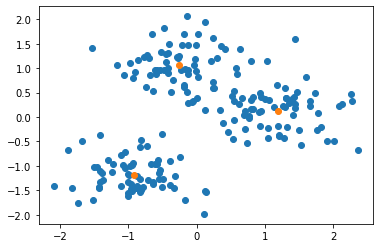

In [ ]:
scat = plt.scatter(
    scaled_features[:,0],
    scaled_features[:,1]
    # kmeans.cluster_centers,
)
plt.scatter(
    kmeans.cluster_centers_[:,0],
    kmeans.cluster_centers_[:,1]
)